Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [567]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

### Скользящее среднее

In [620]:
len_pred=12 # сколько значений будем предсказывать

In [530]:
# функция усредняет ряд скользящим средним, начиная с точки n, и предсказывает одно значение в будущем
def moving_average(series, n):
    s=pd.Series([''])
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    series=s.append(series.rolling(n).mean())
    return series

In [531]:
# функция предсказывает несколько значений в будущем
def next_values(series, n, len_pred):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    for i in range(len_pred):
        preds=series.rolling(n).mean()
        new=preds[-1:].values[0]
        new_ser=pd.Series([new])
        series=series.append(new_ser)
        i+=1
    return series

In [571]:
# функция считает среднюю ошибку предсказанных значений
def mae_cv_ma(n):
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = next_values(train_split, n, len(test_split))
        preds= result[-len(test_split):]
        error = mean_absolute_error(preds, test_split)
        errors.append(error)

    return (np.mean(np.array(errors)))

#### Нестационарный ряд

In [599]:
series = pd.read_csv("international-airline-passengers.csv")["International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"]

In [600]:
# странно импортировалось, последнее значение NaN
series=series[:-1]

In [601]:
# делим на обучающую и валидационную выборки
train, val = series[:-len_pred], series[-len_pred:]

In [602]:
# ищем оптимальный размер окна скользящего среднего
n_for_mov_average=10
min_err=100000
min_n=0
for n in range(1,n_for_mov_average+1):
    err=mae_cv_ma(n)
    if err<=min_err:
        min_err=err
        min_n=n

In [603]:
print(min_err,min_n) # это минимальная средняя ошибка предсказания в кросс-валидации и размер окна

17.0 1


In [604]:
result=next_values(series, min_n, len(val))[-len(val):]

In [605]:
mean_absolute_error(result.values, val.values)

62.666666666666664

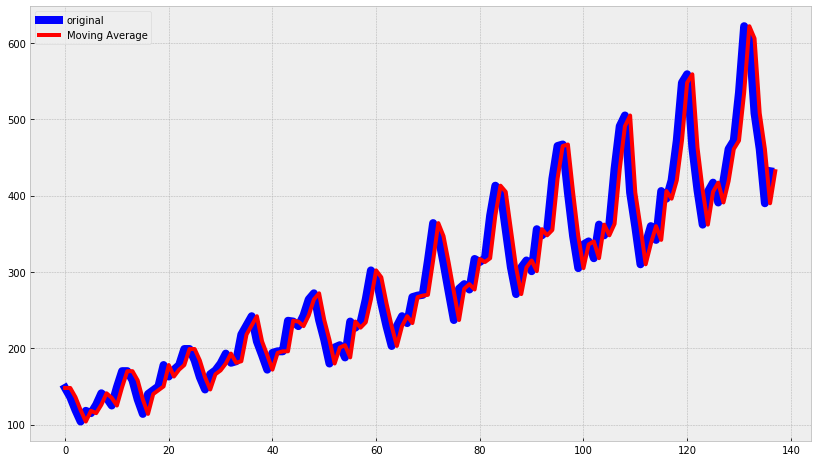

In [606]:
# судя по графику модель неплохо приближает ряд
ser = moving_average(series, 1)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series[7:].tolist(), color='blue', linewidth='8', label='original')
    plt.plot(ser[7:].tolist(), color='red', linewidth='4', label='Moving Average')
    plt.legend()

#### Стационарный ряд

In [607]:
series = pd.read_csv("international-airline-passengers.csv")["International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"]

In [608]:
# странно импортировалось, последнее значение NaN
series=series[:-1]

In [609]:
series = boxcox(series, 0)

In [610]:
series = series[1:] - series[:-1]

In [611]:
train, val = series[:-len_pred], series[-len_pred:]

In [612]:
# делим на обучающую и валидационную выборки
train, val = series[:-len_pred], series[-len_pred:]

In [613]:
# ищем оптимальный размер окна скользящего среднего
n_for_mov_average=10
min_err=100000
min_n=0
for n in range(1,n_for_mov_average+1):
    err=mae_cv_ma(n)
    if err<=min_err:
        min_err=err
        min_n=n

In [614]:
print(min_err,min_n) # это минимальная средняя ошибка предсказания в кросс-валидации и размер окна

15.0 1


In [615]:
result=next_values(series, min_n, len(val))[-len(val):]

In [616]:
mean_absolute_error(result, val) # будущее эта модель предсказывает не очень хорошо=)

0.037321624865429705

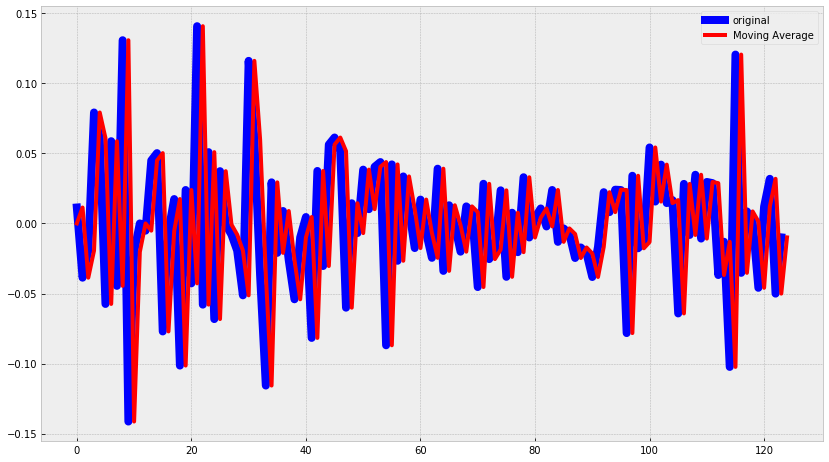

In [617]:
# судя по графику модель неплохо приближает ряд
ser = moving_average(series, 1)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series[7:].tolist(), color='blue', linewidth='8', label='original')
    plt.plot(ser[7:].tolist(), color='red', linewidth='4', label='Moving Average')
    plt.legend()

#### Вывод: модель "сегодня будет так, как вчера" лучше всего приближает ряд.

### Хольт-Винтерс
#### Используем этот метод так как он помогает учесть и сезонность, и тренд

In [3]:
# функция по ряду и по длине сезона возвращает тренд
def initial_trend(series, season_len):
    s=0
    for i in range(len(series)-12):
        s=s+float(series[i + season_len] - series[i]) / season_len    
    return (s / season_len)

In [4]:
# функция по ряду и по длине сезона возвращает сезонные изменения
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [5]:
# функция по ряду и по длине сезона возвращает предсказанные значения
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [6]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [663]:
# функция считает среднее по средней квадратической ошибке для кросс-валидации
def mae_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_absolute_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

#### Нестационарный ряд

In [686]:
len_pred=12

In [687]:
series = pd.read_csv("international-airline-passengers.csv")["International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"]

In [688]:
train, val = series[:-len_pred], series[-len_pred:]

In [689]:
opt = minimize(mae_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [690]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4.416676825430504
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.78428453,  0.36663899,  0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 240
      nit: 9
   status: 0
  success: True
        x: array([1.        , 0.04707206, 1.        ])


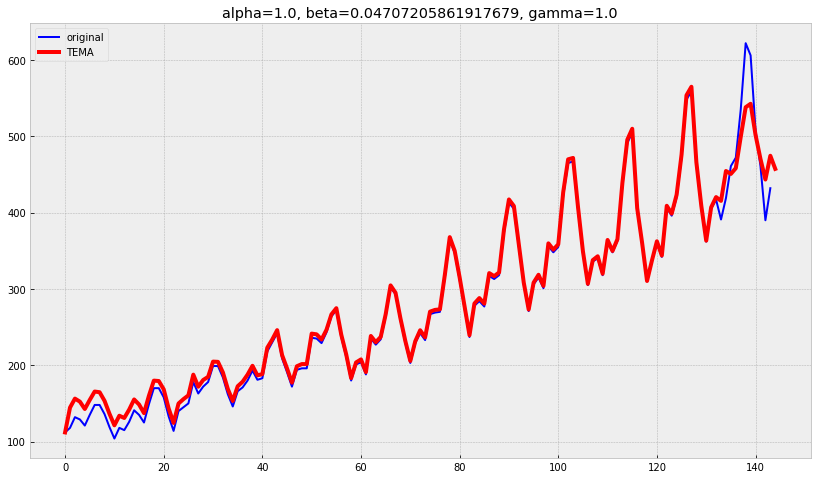

In [691]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [692]:
res=triple_exponential_smoothing(train, 12, 0.07483236, 0.32891783, 0.89339398, len(val))

In [693]:
mean_absolute_error(res[-len_pred:-1], val[:-1])

22.23818070747367

#### Стационарный ряд

In [694]:
series = pd.read_csv("international-airline-passengers.csv")["International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"]

In [695]:
series = boxcox(series, 0)

C:\Users\GreenBenito\anaconda3\lib\site-packages\scipy\stats\morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


In [696]:
series = series[1:] - series[:-1]

In [697]:
series = series[12:] - series[:-12]

In [698]:
train, val = series[:-len_pred], series[-len_pred:]

In [699]:
opt = minimize(mae_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [700]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4.605490141178119
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.72563330e-01,  5.32494582e+00,  1.62749814e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 336
      nit: 16
   status: 0
  success: True
        x: array([0.98195533, 0.03869126, 0.99999272])


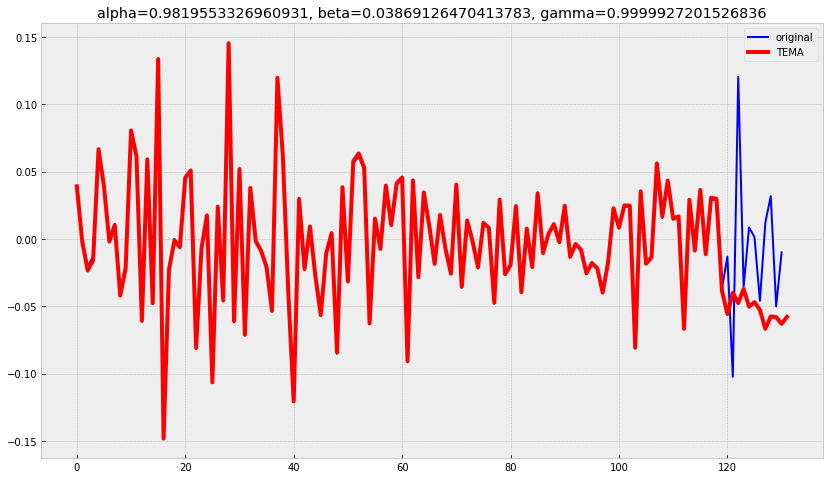

In [701]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [702]:
res=triple_exponential_smoothing(train, 12, 0.07483236, 0.32891783, 0.89339398, len(val))

In [703]:
mean_absolute_error(res[-len_pred:-1], val[:-1])

0.052495211831351064

Вывод:

0.037 и 0.052 - для стационарного ряда mae меньше у модели скользящего среднего

22.238 и 62.66 - для нестационарного ряда mae меньше у модели Хольта Винтерса